In [34]:
# Utility modules
import os
import sys
import re

# Add the project root directory to Python path
notebook_dir = os.path.dirname(os.path.abspath('__file__'))
project_root = os.path.dirname(notebook_dir)
sys.path.insert(0, project_root)

# Configuration
from config import SDR_DATABASE_PATH

# Data manipulation and analysis
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Network analysis
import networkx as nx
import igraph as ig

# Scientific computing
from scipy.sparse import csr_matrix

# Machine learning
from sklearn.preprocessing import scale

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [35]:
def load_sdg_data():
    try:
        sdg_data_main = pd.read_excel(SDR_DATABASE_PATH)
        print(f"Successfully loaded data from {SDR_DATABASE_PATH}")
        return sdg_data_main
    except FileNotFoundError:
        print(f"Error: The file {SDR_DATABASE_PATH} was not found.")
        return None
    except Exception as e:
        print(f"An error occurred while reading the file: {e}")
        return None

sdg_data_main = load_sdg_data()

if sdg_data_main is not None:
    print(f"Loaded data shape: {sdg_data_main.shape}")
else:
    print("Unable to proceed with analysis due to data loading error.")

Successfully loaded data from c:\Repository\sustainable-development-modeling\data\raw\SDR-2022-database.xlsx
Loaded data shape: (3894, 119)


In [36]:
# Filter data to include only years from 2018 onwards
sdg_data_back = sdg_data_main[sdg_data_main['Year'] >= 2018]

# Display the first 5 rows of the filtered data
print(sdg_data_back.head())

   Country Code ISO3      Country  Year  Population       Region Income Group  \
18               AFG  Afghanistan  2018  37171922.0  E_Euro_Asia          LIC   
19               AFG  Afghanistan  2019  38041757.0  E_Euro_Asia          LIC   
20               AFG  Afghanistan  2020  38928341.0  E_Euro_Asia          LIC   
21               AFG  Afghanistan  2021  39835428.0  E_Euro_Asia          LIC   
40               ALB      Albania  2018   2882735.0  E_Euro_Asia         UMIC   

    SDG Index Score  Goal 1 Score  Goal 2 Score  Goal 3 Score  ...  \
18        51.861687     91.417142     52.326286     38.125429  ...   
19        51.847886     91.417142     51.583286     37.612071  ...   
20        51.860679     91.417142     51.583286     38.087500  ...   
21        52.182782     91.417142     51.583286     38.087500  ...   
40        72.208848     90.868000     59.869857     82.817143  ...   

    n_sdg16_cpi  n_sdg16_clabor  n_sdg16_weaponsexp  n_sdg16_rsf  \
18        3.968         

In [37]:
# Filter out data from 2018 onwards
sdg_data = sdg_data_main.drop(sdg_data_main[sdg_data_main['Year'] >= 2018].index)

# Display the first 19 rows of the filtered data
print(sdg_data.head(19))

   Country Code ISO3      Country  Year  Population       Region Income Group  \
0                AFG  Afghanistan  2000  20779957.0  E_Euro_Asia          LIC   
1                AFG  Afghanistan  2001  21606992.0  E_Euro_Asia          LIC   
2                AFG  Afghanistan  2002  22600774.0  E_Euro_Asia          LIC   
3                AFG  Afghanistan  2003  23680871.0  E_Euro_Asia          LIC   
4                AFG  Afghanistan  2004  24726689.0  E_Euro_Asia          LIC   
5                AFG  Afghanistan  2005  25654274.0  E_Euro_Asia          LIC   
6                AFG  Afghanistan  2006  26433058.0  E_Euro_Asia          LIC   
7                AFG  Afghanistan  2007  27100542.0  E_Euro_Asia          LIC   
8                AFG  Afghanistan  2008  27722281.0  E_Euro_Asia          LIC   
9                AFG  Afghanistan  2009  28394806.0  E_Euro_Asia          LIC   
10               AFG  Afghanistan  2010  29185511.0  E_Euro_Asia          LIC   
11               AFG  Afghan

              Goal 1 Score  Goal 2 Score  Goal 3 Score  Goal 4 Score  \
Goal 1 Score      1.000000      0.537421      0.887495      0.784291   
Goal 2 Score      0.537421      1.000000      0.656795      0.624993   
Goal 3 Score      0.887495      0.656795      1.000000      0.862728   
Goal 4 Score      0.784291      0.624993      0.862728      1.000000   
Goal 5 Score      0.454163      0.549329      0.604188      0.684831   

              Goal 5 Score  Goal 6 Score  Goal 7 Score  Goal 8 Score  \
Goal 1 Score      0.454163      0.749455      0.752456      0.534218   
Goal 2 Score      0.549329      0.652767      0.532754      0.637984   
Goal 3 Score      0.604188      0.817959      0.791085      0.685483   
Goal 4 Score      0.684831      0.743789      0.744999      0.647507   
Goal 5 Score      1.000000      0.654283      0.544278      0.619587   

              Goal 9 Score  Goal 10 Score  Goal 11 Score  Goal 12 Score  \
Goal 1 Score      0.597812       0.464367       0.720686   

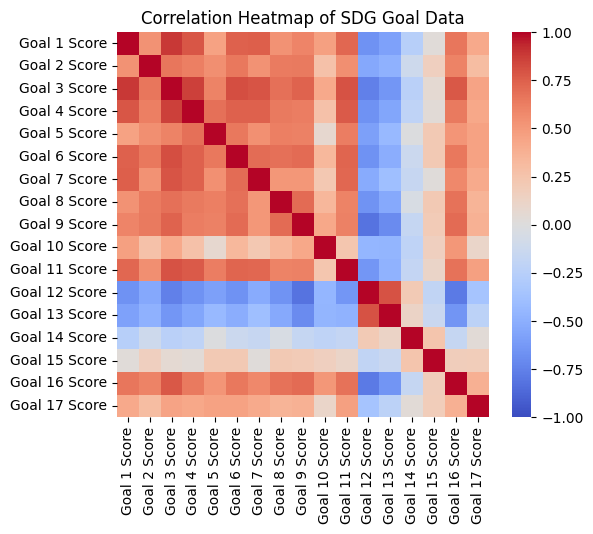

In [38]:
# Initialize dictionary to hold SDG goals and related columns
sdg_goals = {}

# Identify SDG goal columns based on their names
for column in sdg_data.columns:
    if column.startswith('Goal '):  # If column starts with 'Goal ', it's an SDG goal score
        sdg_goals[column] = []
    elif column.startswith('n_sdg'):  # If column starts with 'n_sdg', extract goal number
        n_sdg = column[5:7]
        goal_number = re.sub('[^0-9]', '', n_sdg)  # Extract the numeric part of the column
        goal_key = f'Goal {goal_number} Score'
        if goal_key in sdg_goals:
            sdg_goals[goal_key].append(column)

# Clean the SDG data by removing rows with missing values
sdg_goal_columns = list(sdg_goals.keys())
sdg_goal_data_clean = sdg_data[sdg_goal_columns].dropna()

# Calculate the correlation matrix for the SDG goal data
sdg_pearson_data = sdg_goal_data_clean.corr(method='pearson')

# Display the first few rows of the correlation matrix
print(sdg_pearson_data.head())

# Create a heatmap for the SDG goal correlation matrix
plt.figure(figsize=(6, 5))
sns.heatmap(sdg_pearson_data, annot=False, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap of SDG Goal Data')
plt.show()

In [40]:
# Create a mapping of sub-goals to main SDG goals
sdg_sub_goals = {}
for main_goal, sub_goal_list in sdg_goals.items():
    for sub_goal in sub_goal_list:
        sdg_sub_goals.setdefault(sub_goal, []).append(main_goal)

# Extract the relevant sub-goals from the correlation matrix
sdg_bipart_pearson = sdg_pearson_data[list(sdg_sub_goals.keys())]

# Limit the correlation matrix to rows corresponding to main SDG goals
sdg_bipart_pearson = sdg_bipart_pearson.loc[list(sdg_goals.keys())]

# Display the first few rows of the bipartite correlation matrix
print(sdg_bipart_pearson.head())


KeyError: "None of [Index(['n_sdg1_wpc', 'n_sdg1_320pov', 'n_sdg2_undernsh', 'n_sdg2_stunting',\n       'n_sdg2_wasting', 'n_sdg2_obesity', 'n_sdg2_trophic', 'n_sdg2_crlyld',\n       'n_sdg2_snmi', 'n_sdg2_pestexp', 'n_sdg3_matmort', 'n_sdg3_neonat',\n       'n_sdg3_u5mort', 'n_sdg3_tb', 'n_sdg3_hiv', 'n_sdg3_ncds',\n       'n_sdg3_pollmort', 'n_sdg3_traffic', 'n_sdg3_lifee', 'n_sdg3_fertility',\n       'n_sdg3_births', 'n_sdg3_vac', 'n_sdg3_uhc', 'n_sdg3_swb',\n       'n_sdg4_earlyedu', 'n_sdg4_primary', 'n_sdg4_second', 'n_sdg4_literacy',\n       'n_sdg5_familypl', 'n_sdg5_edat', 'n_sdg5_lfpr', 'n_sdg5_parl',\n       'n_sdg6_water', 'n_sdg6_sanita', 'n_sdg6_freshwat', 'n_sdg6_wastewat',\n       'n_sdg6_scarcew', 'n_sdg7_elecac', 'n_sdg7_cleanfuel', 'n_sdg7_co2twh',\n       'n_sdg7_ren', 'n_sdg8_adjgrowth', 'n_sdg8_slavery', 'n_sdg8_accounts',\n       'n_sdg8_unemp', 'n_sdg8_rights', 'n_sdg8_impacc', 'n_sdg9_intuse',\n       'n_sdg9_mobuse', 'n_sdg9_lpi', 'n_sdg9_uni', 'n_sdg9_articles',\n       'n_sdg9_rdex', 'n_sdg10_gini', 'n_sdg10_palma', 'n_sdg11_slums',\n       'n_sdg11_pm25', 'n_sdg11_pipedwat', 'n_sdg11_transport', 'n_sdg12_msw',\n       'n_sdg12_ewaste', 'n_sdg12_so2prod', 'n_sdg12_so2import',\n       'n_sdg12_nprod', 'n_sdg12_nimport', 'n_sdg12_explastic',\n       'n_sdg13_co2gcp', 'n_sdg13_co2import', 'n_sdg13_co2export',\n       'n_sdg14_cpma', 'n_sdg14_cleanwat', 'n_sdg14_fishstocks',\n       'n_sdg14_trawl', 'n_sdg14_discard', 'n_sdg14_biomar', 'n_sdg15_cpta',\n       'n_sdg15_cpfa', 'n_sdg15_redlist', 'n_sdg15_forchg',\n       'n_sdg15_biofrwter', 'n_sdg16_homicides', 'n_sdg16_detain',\n       'n_sdg16_safe', 'n_sdg16_prs', 'n_sdg16_u5reg', 'n_sdg16_cpi',\n       'n_sdg16_clabor', 'n_sdg16_weaponsexp', 'n_sdg16_rsf',\n       'n_sdg16_justice', 'n_sdg17_govex', 'n_sdg17_oda', 'n_sdg17_govrev',\n       'n_sdg17_cohaven', 'n_sdg17_statperf'],\n      dtype='object')] are in the [columns]"

In [ ]:
sdg_bipart_pearson = sdg_pearson_data[list(sdg_sub_goals.keys())]
sdg_bipart_pearson = sdg_bipart_pearson.loc[list(sdg_goals.keys())]
sdg_bipart_pearson.head()

In [ ]:
graph_sdg_b = nx.empty_graph(0)
sdg_b_labels = {}

A = sp.sparse.csr_matrix(sdg_bipart_pearson.values)
n, m = A.shape

sdg_names = list(sdg_bipart_pearson.index)
graph_sdg_b.add_nodes_from(sdg_names, bipartite=0)
for i in range(n):
    sdg_b_labels[i] = sdg_names[i]

sdg_sub_names = list(sdg_bipart_pearson.columns)
graph_sdg_b.add_nodes_from(sdg_sub_names, bipartite=1)
for i in range(n, n+m):
    sdg_b_labels[i] = sdg_sub_names[i - len(range(n, n+m))]

triples = ((sdg_b_labels[u], sdg_b_labels[n + v], abs(d)) for (u, v, d) in _generate_weighted_edges(A))
graph_sdg_b.add_weighted_edges_from(triples)

fig, ax = plt.subplots()
fig.set_size_inches(15, 4)
nx.draw(graph_sdg_b, with_labels=True, node_color='orange', node_size=400, edge_color='black', linewidths=4, font_size=12)
#nx.write_gml(graph_sdg_b, 'sdg_and_sub_bipartite.gml')


In [ ]:
sdg_sub_pearson = sdg_pearson_data[list(sdg_sub_goals.keys())]
sdg_sub_pearson = sdg_sub_pearson.loc[list(sdg_sub_goals.keys())]
sdg_sub_pearson.head()

In [ ]:
sdg_pearson = sdg_pearson_data[list(sdg_goals.keys())]
sdg_pearson = sdg_pearson.loc[list(sdg_goals.keys())]
sdg_pearson.head()

In [ ]:
sdg_goals_names = list(sdg_goals.keys())
values = sdg_pearson.values
graph_sdg_p = Graph.Weighted_Adjacency((values>0).tolist())
graph_sdg_p = graph_sdg_p.simplify()
graph_sdg_p.es['weight'] = values[values.nonzero()]
graph_sdg_p.vs['label'] = sdg_goals_names
graph_sdg_p = graph_sdg_p.to_networkx()

nx.draw(graph_sdg_p, with_labels=True, node_color='orange', node_size=400, edge_color='black', linewidths=4, font_size=12, pos=nx.spring_layout(graph_sdg_p, k=0.15, weight='value', iterations=50))

In [ ]:
sdg_sub_goals_names = list(sdg_sub_goals.keys())
values = sdg_sub_pearson.values
graph_sdg_sub_p = Graph.Weighted_Adjacency((values>0).tolist())
graph_sdg_sub_p = graph_sdg_sub_p.simplify()
graph_sdg_sub_p.es['weight'] = values[values.nonzero()]
graph_sdg_sub_p.vs['label'] = sdg_sub_goals_names
graph_sdg_sub_p = graph_sdg_sub_p.to_networkx()

nx.draw(graph_sdg_sub_p, with_labels=True, node_color='orange', node_size=400, edge_color='black', linewidths=4, font_size=12, pos=nx.spring_layout(graph_sdg_sub_p, k=0.15, weight='value', iterations=50))

In [ ]:
sdg_goals_names = list(sdg_goals.keys())
values = sdg_pearson.values
graph_sdg_n = Graph.Weighted_Adjacency((values<0).tolist())
graph_sdg_n = graph_sdg_n.simplify()
graph_sdg_n.es['weight'] = values[values.nonzero()]
graph_sdg_n.vs['label'] = sdg_goals_names
graph_sdg_n = graph_sdg_n.to_networkx()

nx.draw(graph_sdg_n, with_labels=True, node_color='orange', node_size=400, edge_color='black', linewidths=4, font_size=12, pos=nx.spring_layout(graph_sdg_n, k=0.15, weight='value', iterations=50))

In [ ]:
sdg_sub_goals_names = list(sdg_sub_goals.keys())
values = sdg_sub_pearson.values
graph_sdg_sub_n = Graph.Weighted_Adjacency((values<0).tolist())
graph_sdg_sub_n = graph_sdg_sub_n.simplify()
graph_sdg_sub_n.es['weight'] = values[values.nonzero()]
graph_sdg_sub_n.vs['label'] = sdg_sub_goals_names
graph_sdg_sub_n = graph_sdg_sub_n.to_networkx()

nx.draw(graph_sdg_sub_n, with_labels=True, node_color='orange', node_size=400, edge_color='black', linewidths=4, font_size=12, pos=nx.spring_layout(graph_sdg_sub_n, k=0.15, weight='value', iterations=50))

In [ ]:
for target_1 in sdg_goals_names:
    figure, ax = plt.subplots(figsize=(20,10))
    goal_name_1 = target_1
    ax = sns.regplot(data=sdg_data, x=goal_name_1, y=goal_name_1, order=1, ax = ax, scatter=False)
    for target_2 in sdg_goals_names:
        if target_2 != target_1:
            goal_name_2 = target_2
            ax = sns.regplot(data=sdg_data, x=goal_name_1, y=goal_name_2, order=1, ax = ax, scatter=False)

In [ ]:
for target_1 in sdg_sub_goals_names:
    figure, ax = plt.subplots(figsize=(20,10))
    goal_name_1 = target_1
    ax = sns.regplot(data=sdg_data, x=goal_name_1, y=goal_name_1, order=1, ax = ax, scatter=False)
    for target_2 in sdg_sub_goals_names:
        if target_2 != target_1:
            goal_name_2 = target_2
            ax = sns.regplot(data=sdg_data, x=goal_name_1, y=goal_name_2, order=1, ax = ax, scatter=False)